In [1]:
import tensorflow_probability as tfp
tfd = tfp.distributions
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import numpy as np
import scipy 
import tqdm
import maxent
import os
tf.random.set_seed(0)
np.random.seed(0)
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
sns.set_context('paper')
sns.set_style('whitegrid',  {'xtick.bottom':True, 'ytick.left':True, 'xtick.color': '#333333', 'ytick.color': '#333333'})
#plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
colors = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e']
%matplotlib inline

2021-08-23 13:53:09.341644: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-9.0/lib64
2021-08-23 13:53:09.341668: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Set-up Prior Distribution

In [2]:
x = np.array([1., 1.])
i = tf.keras.Input((1,))
l = maxent.TrainableInputLayer(x)(i)
d = tfp.layers.DistributionLambda(lambda x: tfd.Normal(loc=x[...,0], scale=tf.math.exp(x[...,1])))(l)
model = maxent.ParameterJoint([lambda x: x], inputs=i, outputs=[d])
model.compile(tf.keras.optimizers.Adam(0.1))
model.summary()
model(tf.constant([1.]))

Model: "parameter_joint"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
trainable_input_layer (Train (None, 2)                 2         
_________________________________________________________________
distribution_lambda (Distrib multiple                  0         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


2021-08-23 13:53:11.307372: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-08-23 13:53:11.310423: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-08-23 13:53:11.310456: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: whitead-workstation
2021-08-23 13:53:11.310463: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: whitead-workstation
2021-08-23 13:53:11.310531: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 390.144.0
2021-08-23 13:53:11.310556: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 390.144.0
2021-08-23 13:53:11.310562: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 390.144.0
2021-08-23 13:53:11.310779: I tensorflow/

<tfp.distributions.Normal 'parameter_joint_distribution_lambda_Normal' batch_shape=[1] event_shape=[] dtype=float32>

## Simulator

In [3]:
def simulate(x):
    y = np.random.normal(loc=x, scale=0.1)
    return y
plt.figure()
unbiased_params = model.sample(100000)
y = simulate(*unbiased_params)
y = np.squeeze(y)

<Figure size 432x288 with 0 Axes>

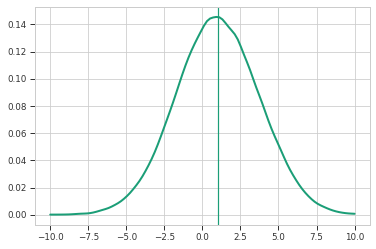

In [4]:
pdf = scipy.stats.gaussian_kde(y)
x = np.linspace(-10, 10, 100)
plt.plot(x, pdf.pdf(x), color=colors[0], linewidth=2)
plt.axvline(np.mean(y), color=colors[0])

## Maximum Entropy Method

In [5]:
r = maxent.Restraint(lambda x: x, 4, maxent.EmptyPrior())

me_model = maxent.MaxentModel([r])
me_model.compile(tf.keras.optimizers.Adam(0.01), 'mean_squared_error')
result = me_model.fit(y, epochs=4, batch_size=128)

2021-08-23 13:53:12.430351: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-08-23 13:53:12.448641: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3298055000 Hz


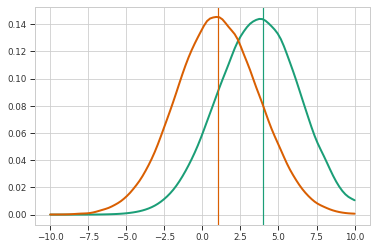

In [6]:
plt.axvline(x=4, color=colors[0])
wpdf = scipy.stats.gaussian_kde(np.squeeze(y), weights=np.squeeze(me_model.traj_weights))
x = np.linspace(-10, 10, 100)
plt.plot(x, wpdf.pdf(x), color=colors[0], linewidth=2)


plt.plot(x, pdf.pdf(x), color=colors[1], linewidth=2)
plt.axvline(np.mean(np.squeeze(y)), color=colors[1])

## Variational MaxEnt

Try to fit to more extreme value - 10

In [7]:
r = maxent.Restraint(lambda x: x, 10, maxent.EmptyPrior())
hme_model = maxent.HyperMaxentModel([r], model, simulate)
hme_model.compile(tf.keras.optimizers.SGD(0.005), 'mean_squared_error')
result = hme_model.fit(epochs=4, sample_batch_size=len(y) // 4, verbose=0)


In [8]:
w2pdf = scipy.stats.gaussian_kde(np.squeeze(hme_model.trajs), weights=np.squeeze(hme_model.traj_weights))

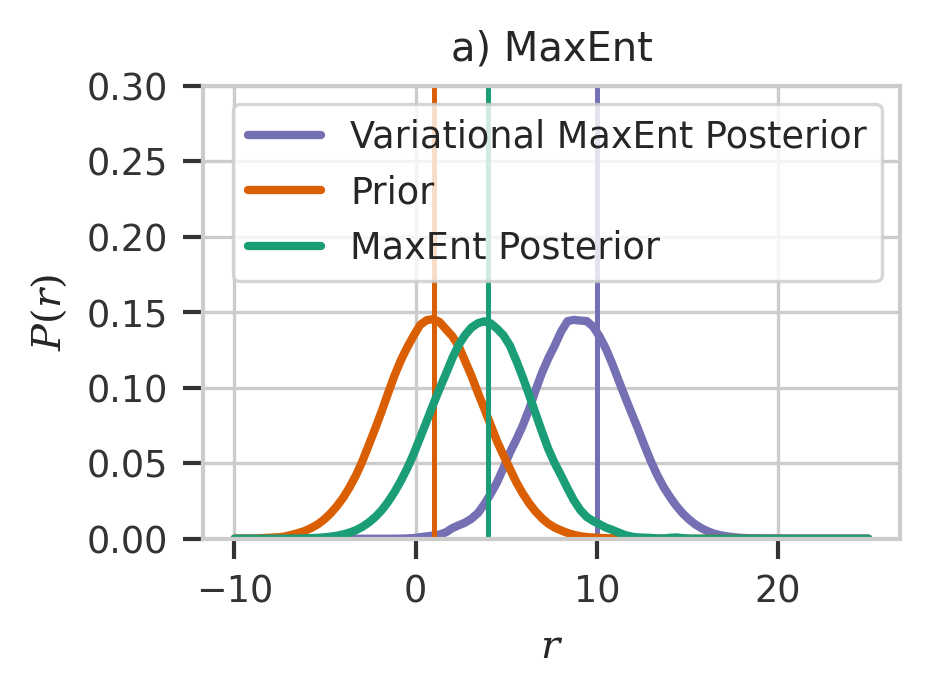

In [9]:
plt.figure(figsize=(3,2), dpi=300)
x = np.linspace(-10, 25, 100)
plt.plot(x, w2pdf.pdf(x), color=colors[2], linewidth=2, label='Variational MaxEnt Posterior')
plt.axvline(x=10, color=colors[2])

plt.plot(x, pdf.pdf(x), color=colors[1], linewidth=2, label='Prior')
plt.axvline(np.mean(np.squeeze(y)), color=colors[1])

plt.plot(x, wpdf.pdf(x), color=colors[0], linewidth=2, label='MaxEnt Posterior')
plt.axvline(x=4, color=colors[0])
plt.ylim(0,0.30)
plt.xlabel(r'$r$')
plt.ylabel(r'$P(r)$')
plt.title('a) MaxEnt')
plt.legend()
plt.savefig('maxent.svg')


## Bayesian Inference Setting

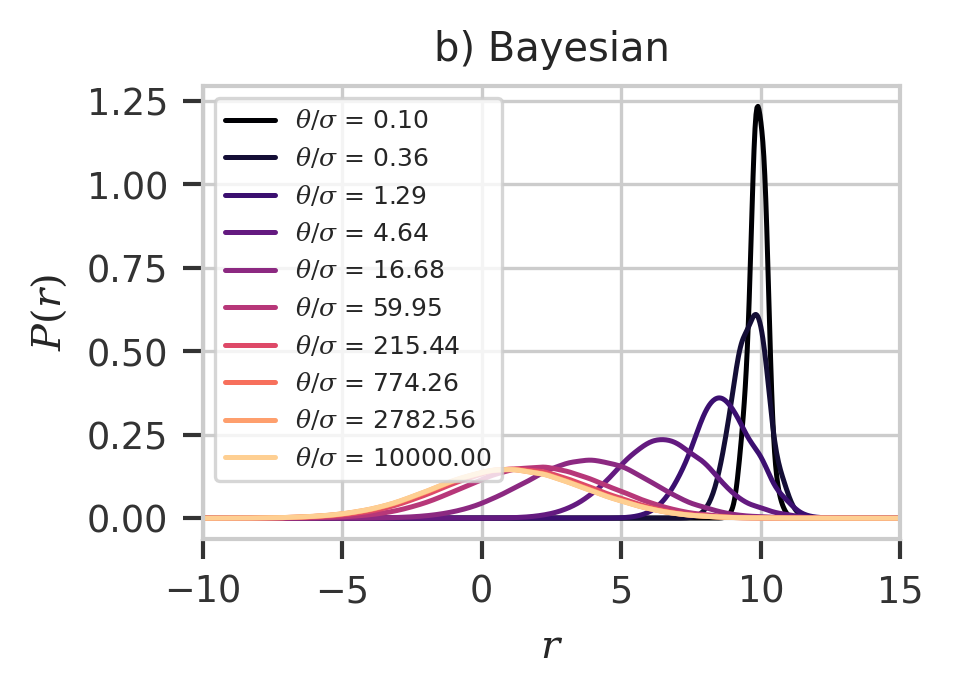

In [10]:
# https://pubmed.ncbi.nlm.nih.gov/26723635/
plt.figure(figsize=(3,2), dpi=300)
x = np.linspace(-10, 25, 1000)
cmap = plt.get_cmap('magma')
prior_theta = 10**np.linspace(-1, 4, 10)
bpdf = np.exp(-(y - 10)**2 / (2 * prior_theta[:, np.newaxis]))
bpdf /= np.sum(bpdf, axis=1)[:, np.newaxis]
for i,p in enumerate(prior_theta):
    ppdf = scipy.stats.gaussian_kde(np.squeeze(y), weights=bpdf[i])    
    plt.plot(x, ppdf.pdf(x), color=cmap(i / len(prior_theta)), label=f'$\\theta/\\sigma$ = {p:.2f}')
plt.legend(fontsize=6)
plt.xlim(-10, 15)
plt.xlabel(r'$r$')
plt.ylabel(r'$P(r)$')
plt.title('b) Bayesian')
plt.savefig('bayes.svg')
plt.show()

## Effects of Observable

In [11]:
bayesian_results = []
#scipy.stats.wasserstein_distance(y, y, u_weights=np.ones_like(y) / len(y), v_weights=bpdf[i])])
x2 = np.linspace(-20, 20, 10000)
for i in range(len(prior_theta)):
    ppdf = scipy.stats.gaussian_kde(np.squeeze(y), weights=bpdf[i])    
    bayesian_results.append([np.sum(ppdf.pdf(x) * x * (x[1] - x[0])),  
          -np.nansum((x[1] - x[0]) * ppdf.pdf(x) * np.log(ppdf.pdf(x)))])
    print(i, bayesian_results[-1])

/tmp/ipykernel_1435766/2403495712.py:7: RuntimeWarning: divide by zero encountered in log
  -np.nansum((x[1] - x[0]) * ppdf.pdf(x) * np.log(ppdf.pdf(x)))])
/tmp/ipykernel_1435766/2403495712.py:7: RuntimeWarning: invalid value encountered in multiply
  -np.nansum((x[1] - x[0]) * ppdf.pdf(x) * np.log(ppdf.pdf(x)))])


0 [9.911016359048263, 0.3042573578163086]
1 [9.631094028403169, 0.9771244951498036]
2 [8.674678518807875, 1.5288348252198851]
3 [6.526128590020792, 1.9553957761896448]
4 [3.7846027053356988, 2.244649224089299]
5 [1.9951996500959481, 2.371265813381091]
6 [1.299596763715296, 2.4118962049488717]
7 [1.0843316455584768, 2.423766089350074]
8 [1.022553823634384, 2.427114909604028]
9 [1.0052135486225569, 2.4280502822459478]


In [12]:
me_results = []
for i in range(-5, 10):
    r = maxent.Restraint(lambda x: x, i, maxent.EmptyPrior())
    m = maxent.MaxentModel([r])
    m.compile(tf.keras.optimizers.Adam(0.001), 'mean_squared_error')
    m.fit(y, epochs=4, batch_size=256, verbose=0)    
    #d = scipy.stats.wasserstein_distance(y, y, u_weights=m.traj_weights)
    ppdf = scipy.stats.gaussian_kde(y, weights=m.traj_weights)    
    d=  -np.nansum((x[1] - x[0]) * ppdf.pdf(x) * np.log(ppdf.pdf(x)))
    me_results.append([i, d])
    print(np.sum(y * m.traj_weights), d)

-4.760423 2.306920593982219
-3.810947 2.369451634523362
-2.8259637 2.4038350683924916
-1.900872 2.4184477780800515
-0.9553167 2.4243713533689775
0.027614225 2.4268825733479122


/tmp/ipykernel_1435766/1265644968.py:9: RuntimeWarning: divide by zero encountered in log
  d=  -np.nansum((x[1] - x[0]) * ppdf.pdf(x) * np.log(ppdf.pdf(x)))
/tmp/ipykernel_1435766/1265644968.py:9: RuntimeWarning: invalid value encountered in multiply
  d=  -np.nansum((x[1] - x[0]) * ppdf.pdf(x) * np.log(ppdf.pdf(x)))


1.0098245 2.4284273710539668
1.9941295 2.429549255552888
2.9686315 2.4306696970584922
3.8970127 2.433814611183493
4.834799 2.443655280531586
5.8534675 2.4694963629429747
6.8461313 2.5148259769252608
7.641946 2.5621808310460468
8.217657 2.5977537791934333


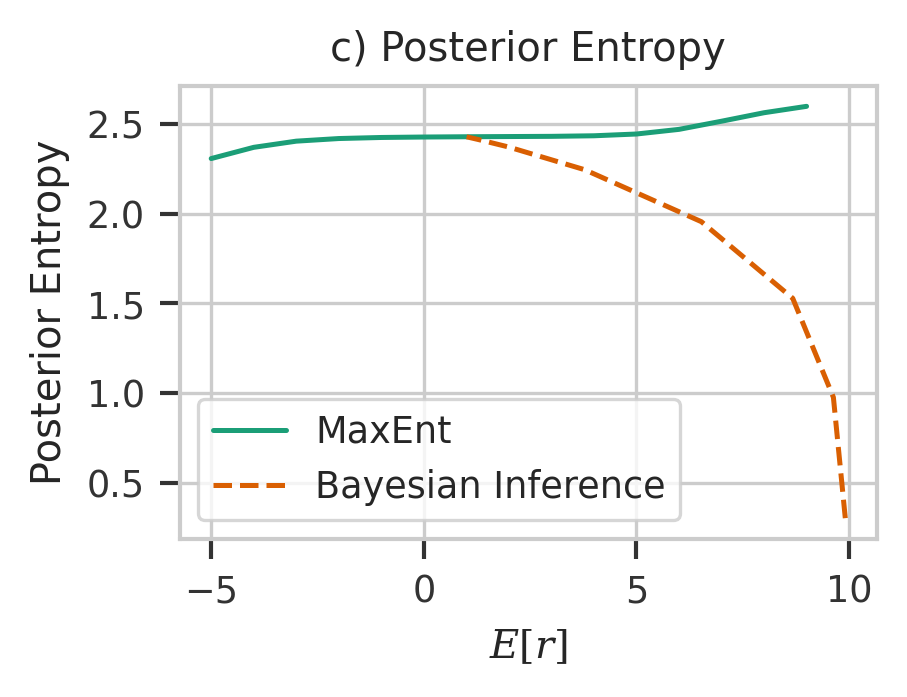

In [13]:
plt.figure(figsize=(3,2), dpi=300)
me_result = np.array(me_results)
bayesian_results = np.array(bayesian_results)
plt.plot(me_result[:, 0], me_result[:,1], label='MaxEnt', color=colors[0])
plt.plot(bayesian_results[:,0], bayesian_results[:,1], linestyle='--', label='Bayesian Inference', color=colors[1])
plt.ylabel('Posterior Entropy')
plt.xlabel('$E[r]$')
plt.legend()
plt.title('c) Posterior Entropy')
plt.savefig('post.svg')
plt.show()


In [14]:
bayesian_results[:]

array([[9.91101636, 0.30425736],
       [9.63109403, 0.9771245 ],
       [8.67467852, 1.52883483],
       [6.52612859, 1.95539578],
       [3.78460271, 2.24464922],
       [1.99519965, 2.37126581],
       [1.29959676, 2.4118962 ],
       [1.08433165, 2.42376609],
       [1.02255382, 2.42711491],
       [1.00521355, 2.42805028]])